# Marron–Wand Benchmark: Optimized vs Classic AdaptiveKDE

Compare the optimized and classic (original) implementations of `sskernel`, `ssvkernel`, and `sshist`
on the **15 Marron–Wand (1992) benchmark densities** — the standard test suite for kernel density estimation.

Each density is a known Gaussian mixture, enabling exact ISE (Integrated Squared Error) computation.

> J. S. Marron and M. P. Wand, "Exact Mean Integrated Squared Error,"
> *The Annals of Statistics*, 20(2):712–736, 1992.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from adaptivekde import (
    sshist, sskernel, ssvkernel,
    sshist_classic, sskernel_classic, ssvkernel_classic,
)

# Plot config
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
})

N_SAMPLES = 1000
N_GRID = 1024
N_REPEATS = 3
NBS_SSKERNEL = 100
NBS_SSVKERNEL = 50
RNG = np.random.default_rng(42)

In [2]:
# ── 15 Marron–Wand densities ──────────────────────────────────────────
# Each is f(x) = sum_j w_j * N(x; mu_j, sigma_j).
# Parameters from Marron & Wand (1992) Table 1 / Marron's Matlab nmpar.m.

MW_DENSITIES = [
    # 1. Gaussian
    {'name': '#1 Gaussian',
     'weights': [1.0],
     'means': [0.0],
     'sigmas': [1.0]},

    # 2. Skewed unimodal
    {'name': '#2 Skewed unimodal',
     'weights': [1/5, 1/5, 3/5],
     'means': [0.0, 1/2, 13/12],
     'sigmas': [1.0, 2/3, 5/9]},

    # 3. Strongly skewed
    {'name': '#3 Strongly skewed',
     'weights': [1/8]*8,
     'means': [3*((2/3)**k - 1) for k in range(8)],
     'sigmas': [(2/3)**k for k in range(8)]},

    # 4. Kurtotic unimodal
    {'name': '#4 Kurtotic unimodal',
     'weights': [2/3, 1/3],
     'means': [0.0, 0.0],
     'sigmas': [1.0, 1/10]},

    # 5. Outlier
    {'name': '#5 Outlier',
     'weights': [1/10, 9/10],
     'means': [0.0, 0.0],
     'sigmas': [1.0, 1/10]},

    # 6. Bimodal
    {'name': '#6 Bimodal',
     'weights': [1/2, 1/2],
     'means': [-1.0, 1.0],
     'sigmas': [2/3, 2/3]},

    # 7. Separated bimodal
    {'name': '#7 Separated bimodal',
     'weights': [1/2, 1/2],
     'means': [-3/2, 3/2],
     'sigmas': [1/2, 1/2]},

    # 8. Asymmetric bimodal
    {'name': '#8 Asymmetric bimodal',
     'weights': [3/4, 1/4],
     'means': [0.0, 3/2],
     'sigmas': [1.0, 1/3]},

    # 9. Trimodal
    {'name': '#9 Trimodal',
     'weights': [9/20, 9/20, 1/10],
     'means': [-6/5, 6/5, 0.0],
     'sigmas': [3/5, 3/5, 1/4]},

    # 10. Claw
    {'name': '#10 Claw',
     'weights': [1/2] + [1/10]*5,
     'means': [0.0] + [(k-2)/2 for k in range(5)],
     'sigmas': [1.0] + [1/10]*5},

    # 11. Double claw
    {'name': '#11 Double claw',
     'weights': [49/100, 49/100] + [1/350]*7,
     'means': [-1.0, 1.0] + [(k-3)/2 for k in range(7)],
     'sigmas': [2/3, 2/3] + [1/100]*7},

    # 12. Asymmetric claw
    # 1/2 N(0,1) + sum_{l=-2}^{2} [2^{1-l}/31] N(l+1/2, (2^{-l}/10)^2)
    # Verified against Marron's nmpar.m Matlab source.
    {'name': '#12 Asymmetric claw',
     'weights': [1/2] + [2**(1-l)/31 for l in range(-2, 3)],
     'means': [0.0] + [l + 1/2 for l in range(-2, 3)],
     'sigmas': [1.0] + [2**(-l)/10 for l in range(-2, 3)]},

    # 13. Asymmetric double claw
    {'name': '#13 Asym. double claw',
     'weights': [46/100, 46/100, 1/300, 1/300, 1/300, 7/300, 7/300, 7/300],
     'means': [-1.0, 1.0, -3/2, -1.0, -1/2, 1/2, 1.0, 3/2],
     'sigmas': [2/3, 2/3, 1/100, 1/100, 1/100, 7/100, 7/100, 7/100]},

    # 14. Smooth comb
    {'name': '#14 Smooth comb',
     'weights': [2**(5-k)/63 for k in range(6)],
     'means': [(65 - 96*(1/2)**k)/21 for k in range(6)],
     'sigmas': [(32/63)*(1/2)**k for k in range(6)]},

    # 15. Discrete comb
    {'name': '#15 Discrete comb',
     'weights': [2/7, 2/7, 2/7, 1/21, 1/21, 1/21],
     'means': [(12*k - 15)/7 for k in range(6)],
     'sigmas': [2/7, 2/7, 2/7, 1/21, 1/21, 1/21]},
]


def mw_pdf(x, density):
    """Evaluate true Marron–Wand density at points x."""
    x = np.asarray(x)
    result = np.zeros_like(x, dtype=float)
    for w, mu, sig in zip(density['weights'], density['means'], density['sigmas']):
        result += w / (sig * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sig)**2)
    return result


def mw_sample(n, density, rng):
    """Draw n samples from a Marron–Wand Gaussian mixture."""
    weights = np.array(density['weights'])
    means = np.array(density['means'])
    sigmas = np.array(density['sigmas'])
    # choose component
    components = rng.choice(len(weights), size=n, p=weights/weights.sum())
    # sample from chosen Gaussian
    return rng.normal(means[components], sigmas[components])


def mw_support(density, margin=5):
    """Return (lo, hi) covering ±margin*sigma from outermost component."""
    means = np.array(density['means'])
    sigmas = np.array(density['sigmas'])
    lo = np.min(means - margin * sigmas)
    hi = np.max(means + margin * sigmas)
    return lo, hi


# Verify all weights sum to 1
for i, d in enumerate(MW_DENSITIES):
    s = sum(d['weights'])
    assert abs(s - 1.0) < 1e-12, f"#{i+1} {d['name']}: weights sum to {s}"
print(f'{len(MW_DENSITIES)} densities defined (all weights verified)')

15 densities defined (all weights verified)


In [3]:
# ── ISE and timing helpers ────────────────────────────────────────────

def compute_ise(y_est, t_fine, f_true):
    """Integrated squared error via trapezoidal rule."""
    return np.trapezoid((y_est - f_true)**2, t_fine)


def hist_to_density(x, optN, t_fine):
    """Build piecewise-constant histogram density on fine grid."""
    counts, edges = np.histogram(x, bins=optN, density=True)
    # assign each t_fine point to a bin; zero outside histogram range
    idx = np.digitize(t_fine, edges) - 1
    y = np.zeros_like(t_fine)
    mask = (idx >= 0) & (idx < len(counts))
    y[mask] = counts[idx[mask]]
    return y, edges


def timed_run(func, n_repeats=N_REPEATS):
    """Run func() n_repeats times, return (result, median_cpu_seconds)."""
    times = []
    result = None
    for _ in range(n_repeats):
        np.random.seed(0)
        t0 = time.process_time()
        result = func()
        t1 = time.process_time()
        times.append(t1 - t0)
    return result, np.median(times)


print('Helpers defined')

Helpers defined


In [4]:
# ── Run all 15 × 6 method combinations ───────────────────────────────

results = []

for i, density in enumerate(MW_DENSITIES):
    print(f'[{i+1:2d}/15] {density["name"]}', end='', flush=True)

    # Sample and build evaluation grid
    x = mw_sample(N_SAMPLES, density, RNG)
    lo, hi = mw_support(density)
    # Extend support slightly to cover sample range
    lo = min(lo, x.min() - 0.5)
    hi = max(hi, x.max() + 0.5)
    t_fine = np.linspace(lo, hi, N_GRID)
    f_true = mw_pdf(t_fine, density)

    rec = {'name': density['name'], 'x': x, 't_fine': t_fine, 'f_true': f_true}

    # --- sskernel (optimized) ---
    res, dt = timed_run(lambda: sskernel(x, tin=t_fine, nbs=NBS_SSKERNEL))
    y_est = res[0]
    rec['sskernel'] = {'y': y_est, 'ise': compute_ise(y_est, t_fine, f_true), 'time': dt}

    # --- sskernel (classic) ---
    res, dt = timed_run(lambda: sskernel_classic(x, tin=t_fine, nbs=NBS_SSKERNEL))
    y_est = res[0]
    rec['sskernel_classic'] = {'y': y_est, 'ise': compute_ise(y_est, t_fine, f_true), 'time': dt}

    # --- ssvkernel (optimized) ---
    res, dt = timed_run(lambda: ssvkernel(x, tin=t_fine, nbs=NBS_SSVKERNEL))
    y_est = res[0]
    rec['ssvkernel'] = {'y': y_est, 'ise': compute_ise(y_est, t_fine, f_true), 'time': dt}

    # --- ssvkernel (classic) ---
    res, dt = timed_run(lambda: ssvkernel_classic(x, tin=t_fine, nbs=NBS_SSVKERNEL))
    y_est = res[0]
    rec['ssvkernel_classic'] = {'y': y_est, 'ise': compute_ise(y_est, t_fine, f_true), 'time': dt}

    # --- sshist (optimized) ---
    res, dt = timed_run(lambda: sshist(x))
    optN = res[0]
    y_hist, hist_edges = hist_to_density(x, optN, t_fine)
    rec['sshist'] = {'y': y_hist, 'edges': hist_edges, 'optN': optN,
                     'ise': compute_ise(y_hist, t_fine, f_true), 'time': dt}

    # --- sshist (classic) ---
    res, dt = timed_run(lambda: sshist_classic(x))
    optN_c = res[0]
    y_hist_c, hist_edges_c = hist_to_density(x, optN_c, t_fine)
    rec['sshist_classic'] = {'y': y_hist_c, 'edges': hist_edges_c, 'optN': optN_c,
                             'ise': compute_ise(y_hist_c, t_fine, f_true), 'time': dt}

    results.append(rec)
    print(' ✓')

print('Done!')

[ 1/15] #1 Gaussian

 ✓
[ 2/15] #2 Skewed unimodal

 ✓
[ 3/15] #3 Strongly skewed

 ✓
[ 4/15] #4 Kurtotic unimodal

 ✓
[ 5/15] #5 Outlier

 ✓
[ 6/15] #6 Bimodal

 ✓
[ 7/15] #7 Separated bimodal

 ✓
[ 8/15] #8 Asymmetric bimodal

 ✓
[ 9/15] #9 Trimodal

 ✓
[10/15] #10 Claw

 ✓
[11/15] #11 Double claw

 ✓
[12/15] #12 Asymmetric claw

 ✓
[13/15] #13 Asym. double claw

 ✓
[14/15] #14 Smooth comb

 ✓
[15/15] #15 Discrete comb

 ✓
Done!


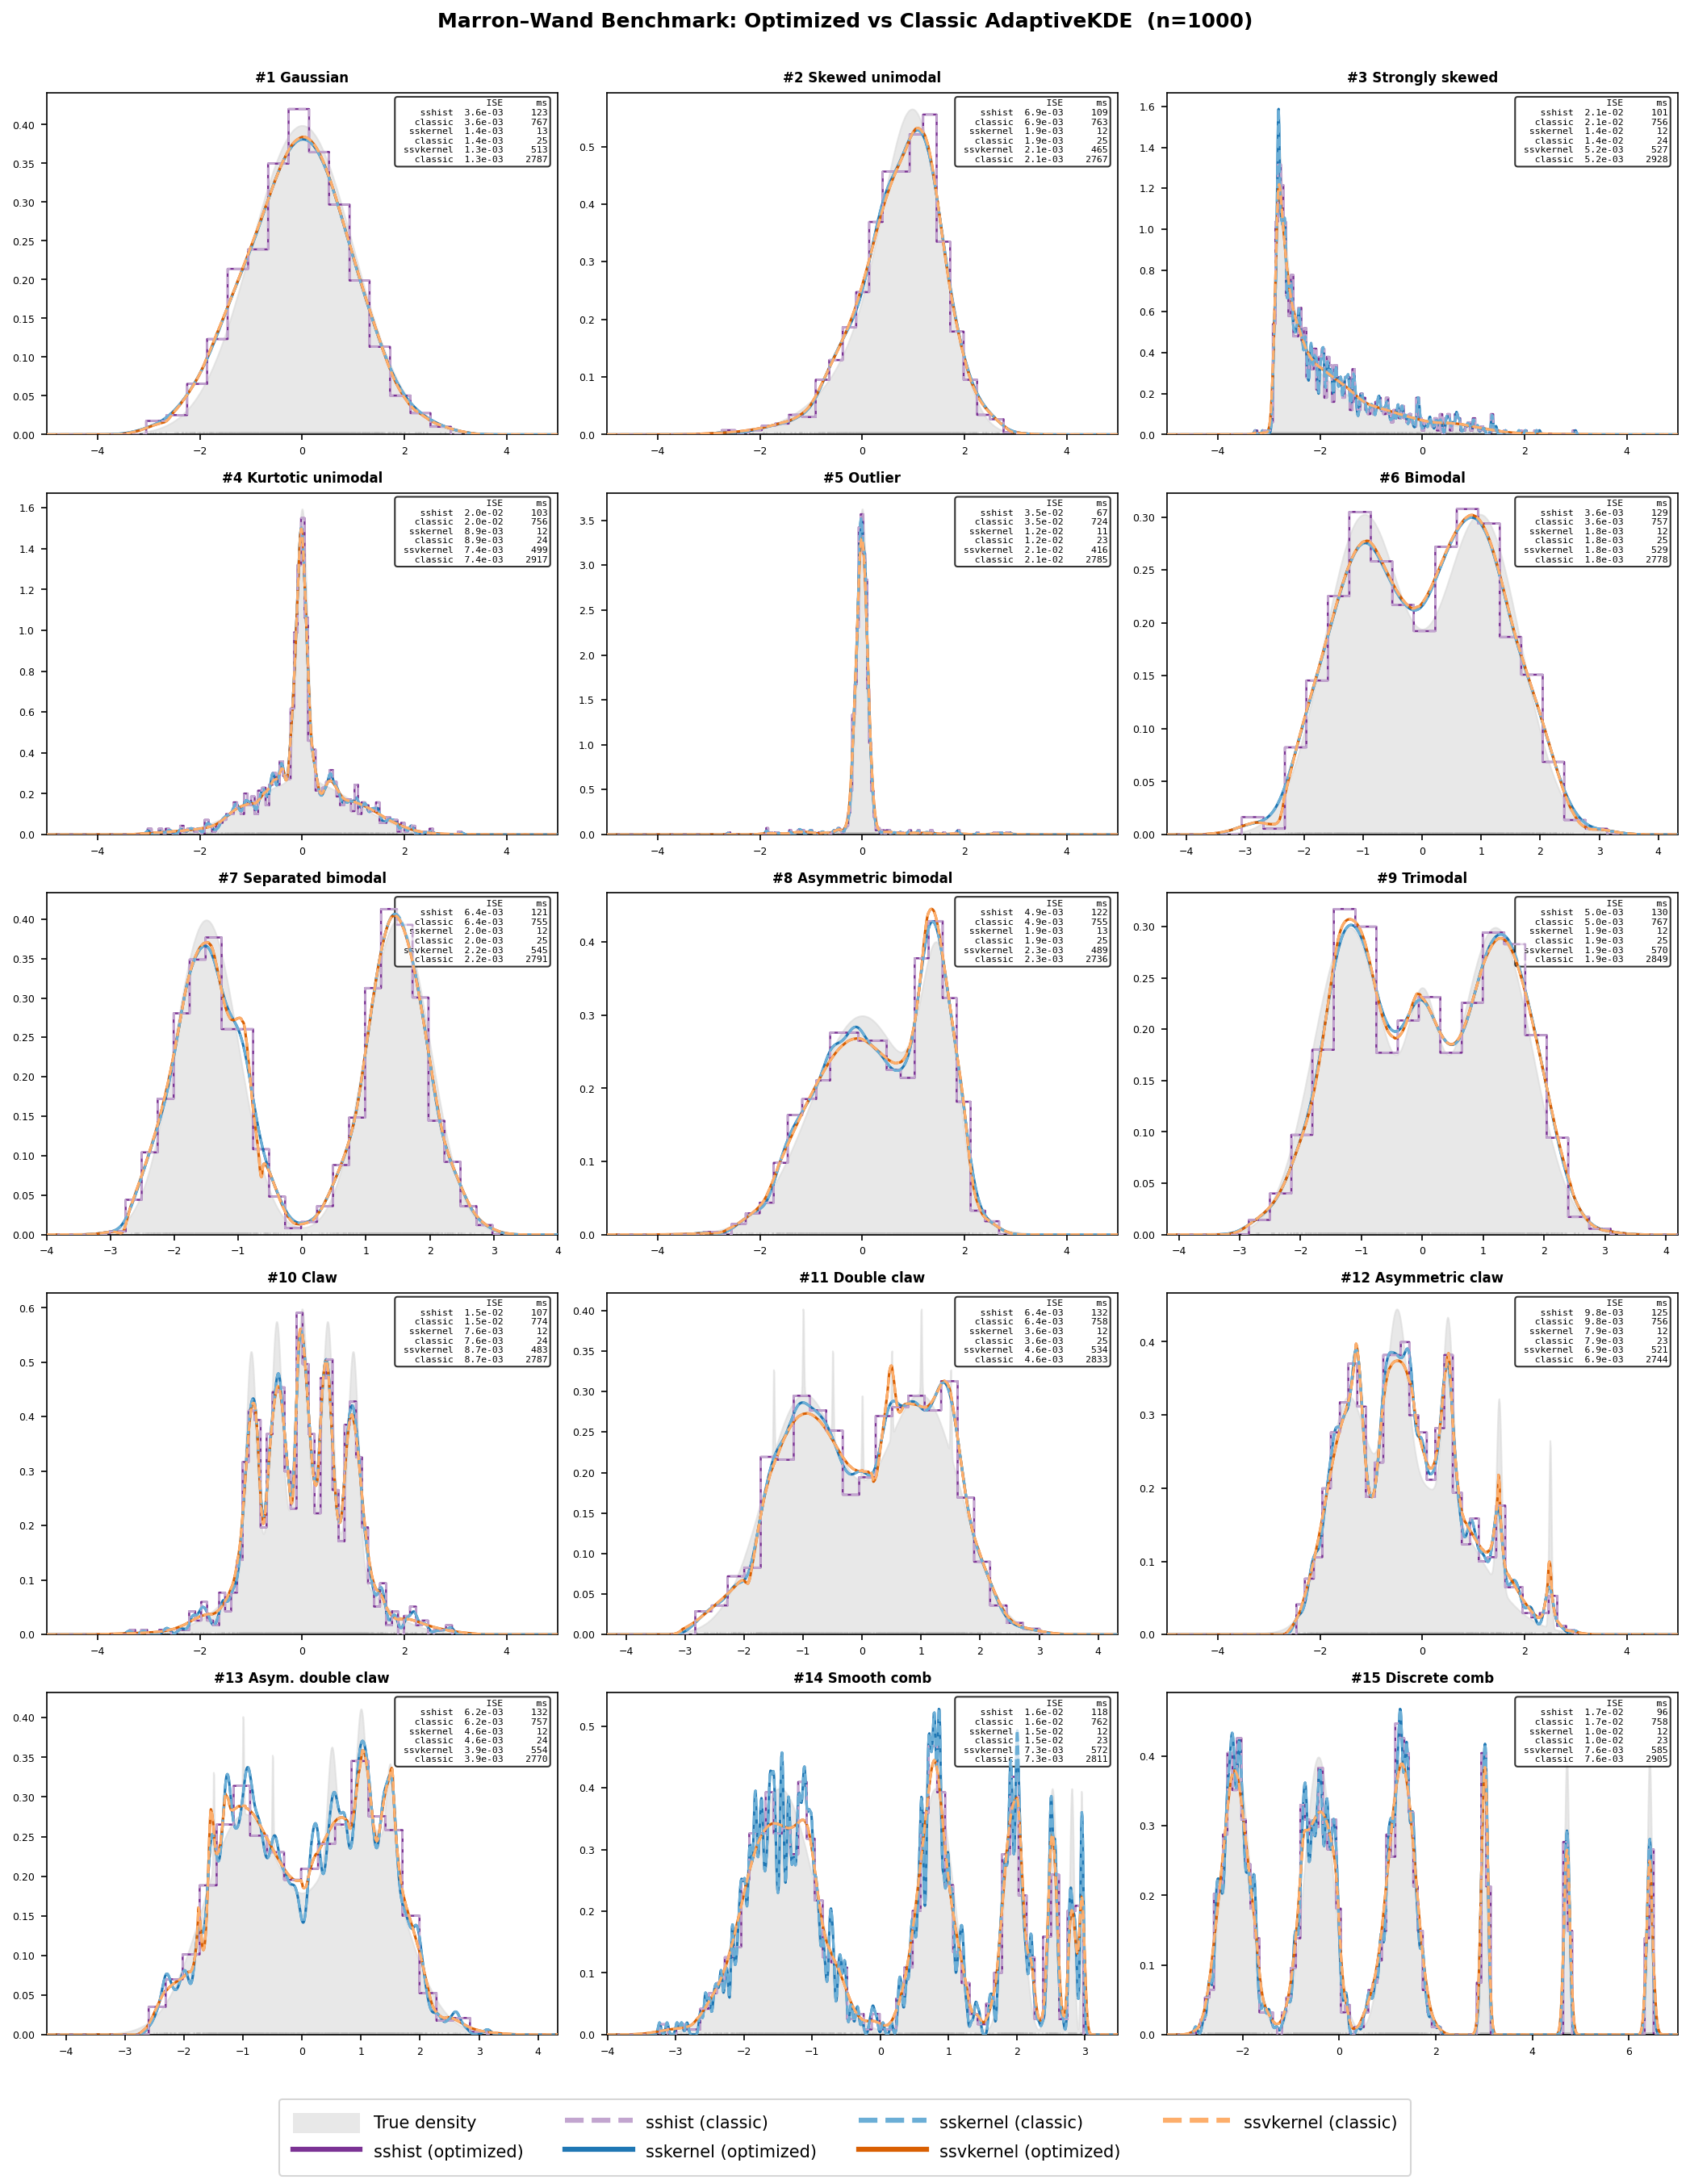

Figure saved to tests/compare_methods.png


In [5]:
# ── 5×3 figure ────────────────────────────────────────────────────────

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Different colors for optimized (dark) vs classic (light) per method
CLR_SSKERNEL_OPT = '#1f77b4'   # dark blue
CLR_SSKERNEL_CLS = '#6baed6'   # light blue
CLR_SSVKERNEL_OPT = '#d95f02'  # dark orange
CLR_SSVKERNEL_CLS = '#fdae6b'  # light orange
CLR_SSHIST_OPT = '#7b3294'    # dark purple
CLR_SSHIST_CLS = '#c2a5cf'    # light purple

fig, axes = plt.subplots(5, 3, figsize=(14, 18))

for idx, (rec, ax) in enumerate(zip(results, axes.flat)):
    t = rec['t_fine']
    x = rec['x']

    # Rug plot
    ax.plot(x, np.zeros_like(x), '|', color='0.6', markersize=3, alpha=0.4, zorder=0)

    # True density — light gray filled area only
    ax.fill_between(t, rec['f_true'], color='0.85', alpha=0.6, zorder=0.5)

    # Optimized: sshist (behind) → sskernel → ssvkernel (front)
    ax.step(t, rec['sshist']['y'], color=CLR_SSHIST_OPT, lw=1.2, where='mid', zorder=2)
    ax.plot(t, rec['sskernel']['y'], color=CLR_SSKERNEL_OPT, lw=1.5, zorder=3)
    ax.plot(t, rec['ssvkernel']['y'], color=CLR_SSVKERNEL_OPT, lw=1.5, zorder=4)

    # Classic: sshist (behind) → sskernel → ssvkernel (front)
    ax.step(t, rec['sshist_classic']['y'], color=CLR_SSHIST_CLS, lw=1.2, ls='--', where='mid', zorder=5)
    ax.plot(t, rec['sskernel_classic']['y'], color=CLR_SSKERNEL_CLS, lw=1.5, ls='--', zorder=6)
    ax.plot(t, rec['ssvkernel_classic']['y'], color=CLR_SSVKERNEL_CLS, lw=1.5, ls='--', zorder=7)

    ax.set_title(rec['name'], fontsize=8, fontweight='bold')
    ax.set_xlim(t[0], t[-1])
    ax.set_ylim(bottom=0)

    # --- Compact annotation: sshist → sskernel → ssvkernel ---
    methods = [
        ('sshist',     CLR_SSHIST_OPT),
        ('sskernel',   CLR_SSKERNEL_OPT),
        ('ssvkernel',  CLR_SSVKERNEL_OPT),
    ]
    lines = ['            ISE      ms']
    for mname, clr in methods:
        r_opt = rec[mname]
        r_cls = rec[mname + '_classic']
        lines.append(f'{mname:>10s}  {r_opt["ise"]:.1e}  {r_opt["time"]*1000:6.0f}')
        lines.append(f'{"classic":>10s}  {r_cls["ise"]:.1e}  {r_cls["time"]*1000:6.0f}')
    txt = '\n'.join(lines)
    ax.text(0.98, 0.98, txt, transform=ax.transAxes,
            fontsize=5.5, fontfamily='monospace',
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Shared legend: sshist → sskernel → ssvkernel
LW_LEG = 3.0
legend_elements = [
    Patch(facecolor='0.85', edgecolor='none', alpha=0.6, label='True density'),
    Line2D([0], [0], color=CLR_SSHIST_OPT,    lw=LW_LEG, ls='-',  label='sshist (optimized)'),
    Line2D([0], [0], color=CLR_SSHIST_CLS,     lw=LW_LEG, ls='--', label='sshist (classic)'),
    Line2D([0], [0], color=CLR_SSKERNEL_OPT,  lw=LW_LEG, ls='-',  label='sskernel (optimized)'),
    Line2D([0], [0], color=CLR_SSKERNEL_CLS,   lw=LW_LEG, ls='--', label='sskernel (classic)'),
    Line2D([0], [0], color=CLR_SSVKERNEL_OPT, lw=LW_LEG, ls='-',  label='ssvkernel (optimized)'),
    Line2D([0], [0], color=CLR_SSVKERNEL_CLS,  lw=LW_LEG, ls='--', label='ssvkernel (classic)'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=10,
           frameon=True, fancybox=True, handlelength=4.0, handleheight=1.5,
           columnspacing=2.5, borderpad=0.8)

fig.suptitle('Marron–Wand Benchmark: Optimized vs Classic AdaptiveKDE  (n=1000)',
             fontsize=12, fontweight='bold', y=0.995)
fig.tight_layout(rect=[0, 0.05, 1, 0.99])
fig.savefig('tests/compare_methods.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved to tests/compare_methods.png')

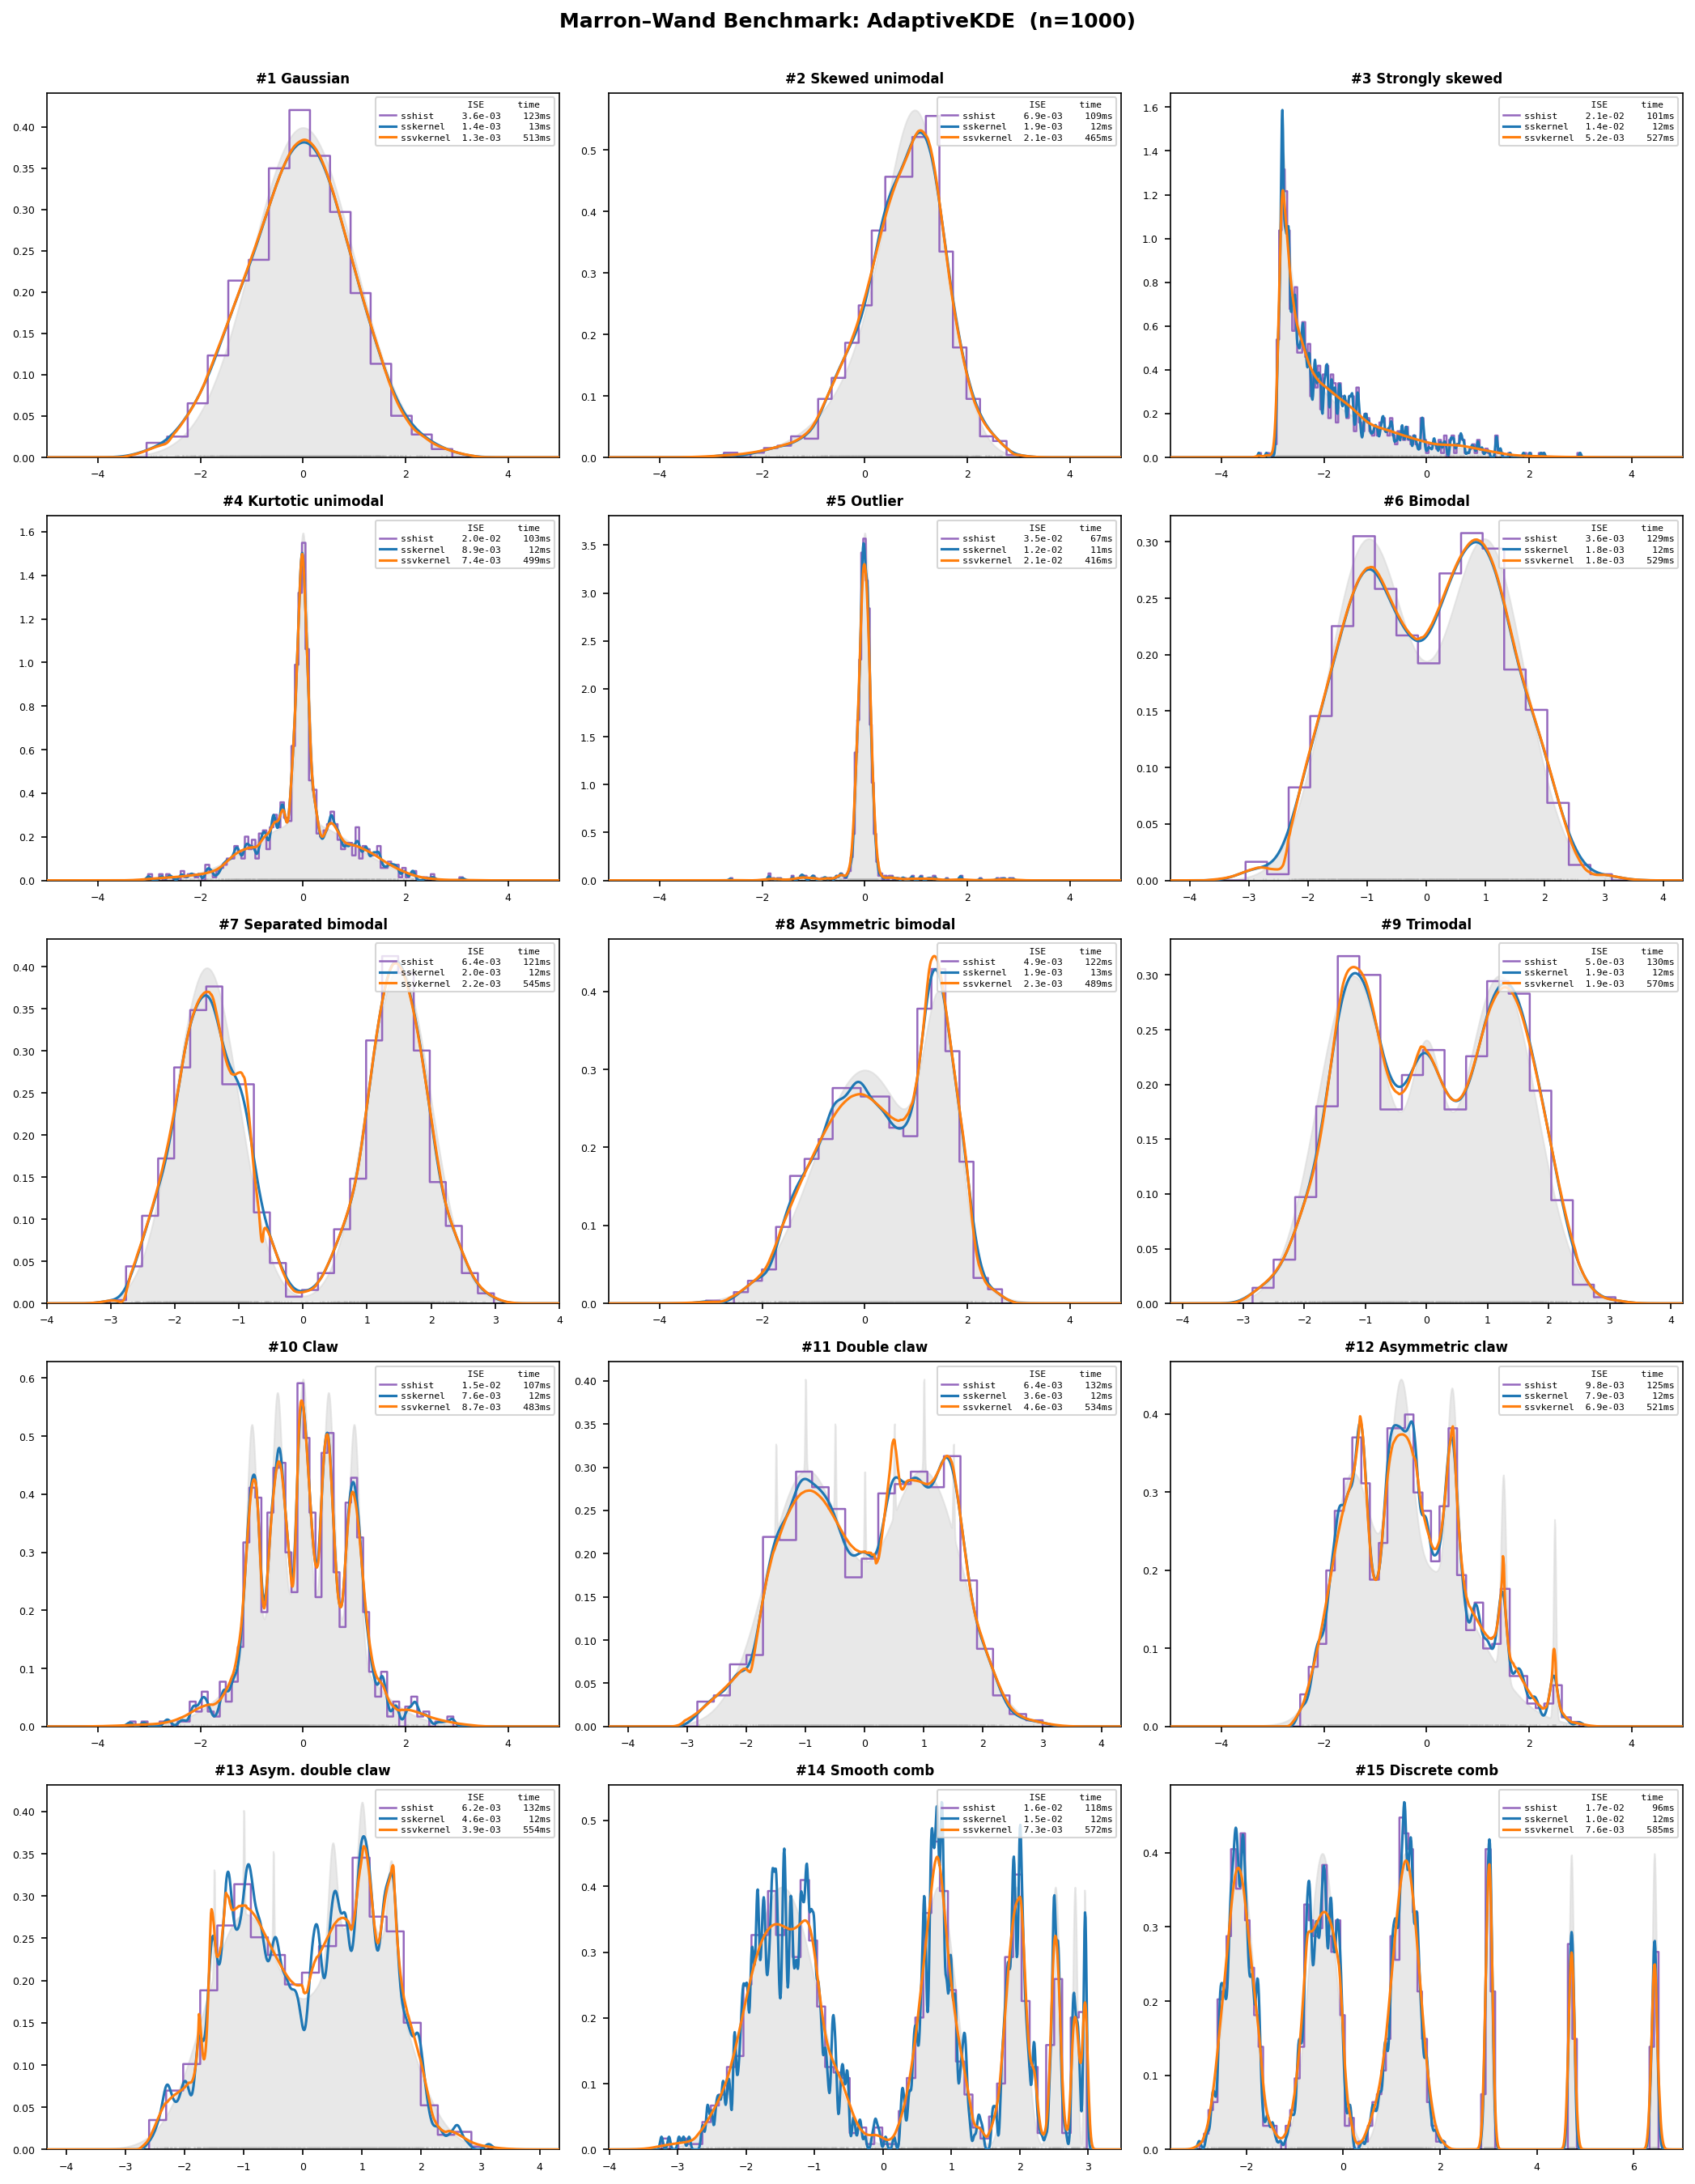

Figure saved to tests/compare_methods_optimized.png


In [6]:
# ── 5×3 figure (optimized only, legend in subplots) ──────────────────

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

CLR_SSKERNEL = '#1f77b4'   # blue
CLR_SSVKERNEL = '#ff7f0e'  # orange
CLR_SSHIST = '#9467bd'     # purple

fig2, axes2 = plt.subplots(5, 3, figsize=(14, 18))

for idx, (rec, ax) in enumerate(zip(results, axes2.flat)):
    t = rec['t_fine']
    x = rec['x']

    # Rug plot
    ax.plot(x, np.zeros_like(x), '|', color='0.6', markersize=3, alpha=0.4, zorder=0)

    # True density — light gray filled area only
    ax.fill_between(t, rec['f_true'], color='0.85', alpha=0.6, zorder=0.5)

    # Optimized: sshist (behind) → sskernel → ssvkernel (front)
    ax.step(t, rec['sshist']['y'], color=CLR_SSHIST, lw=1.2, where='mid', zorder=2)
    ax.plot(t, rec['sskernel']['y'], color=CLR_SSKERNEL, lw=1.5, zorder=3)
    ax.plot(t, rec['ssvkernel']['y'], color=CLR_SSVKERNEL, lw=1.5, zorder=4)

    ax.set_title(rec['name'], fontsize=8, fontweight='bold')
    ax.set_xlim(t[0], t[-1])
    ax.set_ylim(bottom=0)

    # --- Per-subplot legend with ISE and ms ---
    methods = [
        ('sshist',    CLR_SSHIST,    1.2),
        ('sskernel',  CLR_SSKERNEL,  1.5),
        ('ssvkernel', CLR_SSVKERNEL, 1.5),
    ]
    handles = []
    for mname, clr, lw in methods:
        r = rec[mname]
        label = f'{mname:<9s}  {r["ise"]:.1e}  {r["time"]*1000:5.0f}ms'
        handles.append(Line2D([0], [0], color=clr, lw=lw, ls='-', label=label))
    # Header as invisible handle
    header = Line2D([0], [0], color='none', label='            ISE      time')
    ax.legend(handles=[header] + handles, loc='upper right', fontsize=5.5,
              prop={'family': 'monospace', 'size': 5.5},
              framealpha=0.8, edgecolor='0.8', borderpad=0.4,
              handlelength=1.8, handletextpad=0.5, labelspacing=0.3)

fig2.suptitle('Marron–Wand Benchmark: AdaptiveKDE  (n=1000)',
              fontsize=12, fontweight='bold', y=0.995)
fig2.tight_layout(rect=[0, 0, 1, 0.99])
fig2.savefig('tests/compare_methods_optimized.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved to tests/compare_methods_optimized.png')

In [7]:
# ── Summary table ─────────────────────────────────────────────────────

header = f'{"Density":<25s}  {"sskernel":>10s} {"classic":>10s}  {"ssvkernel":>10s} {"classic":>10s}  {"sshist":>10s} {"classic":>10s}'
print('ISE (×1e-3)')
print(header)
print('-' * len(header))
for rec in results:
    name = rec['name']
    vals = []
    for m in ['sskernel', 'sskernel_classic', 'ssvkernel', 'ssvkernel_classic', 'sshist', 'sshist_classic']:
        vals.append(f'{rec[m]["ise"]*1000:10.2f}')
    print(f'{name:<25s}  {vals[0]} {vals[1]}  {vals[2]} {vals[3]}  {vals[4]} {vals[5]}')

print()
print('CPU time (ms)')
print(header)
print('-' * len(header))
for rec in results:
    name = rec['name']
    vals = []
    for m in ['sskernel', 'sskernel_classic', 'ssvkernel', 'ssvkernel_classic', 'sshist', 'sshist_classic']:
        vals.append(f'{rec[m]["time"]*1000:10.1f}')
    print(f'{name:<25s}  {vals[0]} {vals[1]}  {vals[2]} {vals[3]}  {vals[4]} {vals[5]}')

ISE (×1e-3)
Density                      sskernel    classic   ssvkernel    classic      sshist    classic
----------------------------------------------------------------------------------------------
#1 Gaussian                      1.36       1.36        1.31       1.31        3.64       3.64
#2 Skewed unimodal               1.91       1.91        2.07       2.07        6.89       6.89
#3 Strongly skewed              13.89      13.89        5.23       5.23       21.24      21.24
#4 Kurtotic unimodal             8.94       8.94        7.41       7.41       19.77      19.77
#5 Outlier                      12.28      12.28       21.11      21.11       34.62      34.62
#6 Bimodal                       1.79       1.79        1.80       1.80        3.62       3.62
#7 Separated bimodal             2.00       2.00        2.17       2.17        6.38       6.38
#8 Asymmetric bimodal            1.92       1.92        2.34       2.34        4.89       4.89
#9 Trimodal                      1.92 